## Seizure Detection Project

### What is EEG?

An electroencephalogram (EEG) is a test that detects electrical activity in your brain using small, metal discs (electrodes) attached to your scalp. Your brain cells communicate via electrical impulses and are active all the time, even when you're asleep. This activity shows up as wavy lines on an EEG recording.

An EEG can determine changes in brain activity that might be useful in diagnosing brain disorders, especially epilepsy or another seizure disorder. An EEG might also be helpful for diagnosing or treating the following disorders:

Brain tumor
Brain damage from head injury
Brain dysfunction that can have a variety of causes (encephalopathy)
Inflammation of the brain (encephalitis)
Stroke
Sleep disorders

Source: https://www.mayoclinic.org/tests-procedures/eeg/about/pac-20393875


### What are brainwaves?

Brainwaves are electrical impulses in the brain. An individual’s behavior, emotions, and thoughts are communicated between neurons within our brains. All brainwaves are produced by synchronised electrical pulses from masses of neurons communicating with each other. Our brainwaves occur at various frequencies. Some are fast and some are slow. The classic names of these EEG bands are delta, theta, alpha, beta, and gamma. They are measured in cycles per second or hertz (Hz).

Source: https://www.sinhaclinic.com/what-are-brainwaves/

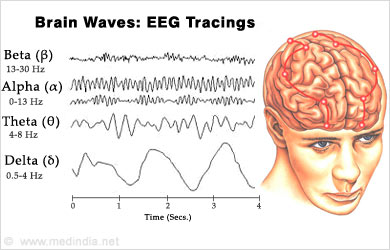

### What is Seizure?

A seizure is a sudden, uncontrolled electrical disturbance in the brain. It can cause changes in your behavior, movements or feelings, and in levels of consciousness. Having two or more seizures at least 24 hours apart that aren't brought on by an identifiable cause is generally considered to be epilepsy.

Source: https://www.mayoclinic.org/diseases-conditions/seizure/symptoms-causes/syc-20365711

### How does a Seizure look on an EEG?

When a seizure happens during an EEG, the normal pattern of brain activity that is seen on the EEG reading changes, and different brain activity can be seen. In focal seizures the change in brain activity can be seen only on the electrodes on the part of the brain the seizure is happening in.

Source: https://epilepsysociety.org.uk/about-epilepsy/diagnosing-epilepsy/closer-look-eeg

In epilepsy the brain's electrical rhythms have a tendency to become imbalanced, resulting in recurrent seizures. In patients with seizures, the normal electrical pattern is disrupted by sudden and synchronized bursts of electrical energy that may briefly affect their consciousness, movements or sensations.

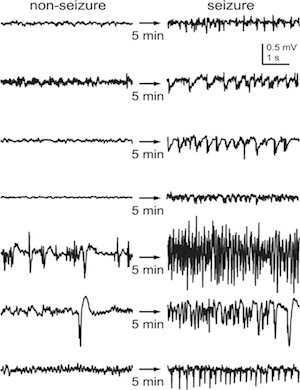

Source: https://www.nature.com/articles/s41598-019-56958-y

### EEG data Preprocessing Step:

In general, preprocessing is the procedure of transforming raw data into a format that is more suitable for further analysis and interpretable for the user. In the case of EEG data, preprocessing usually refers to removing noise from the data to get closer to the true neural signals. There are several reasons why preprocessing is necessary for EEG data. First of all, the signals that are picked up from the scalp are not necessarily an accurate representation of the signals originating from the brain, as the spatial information gets lost. Secondly, EEG data tends to contain a lot of noise which can obscure weaker EEG signals. Artifacts such as blinking or muscle movement can contaminate the data and distort the picture. Finally, we want to separate the relevant neural signals from random neural activity that occurs during EEG recordings.

Source: http://learn.neurotechedu.com/preprocessing/


During this project I used CHB-MIT dataset (Source: https://physionet.org). Each sample has 23 channels for 23 connected electrodes. I have chosen below sample (seizure happens):<br>
[01_05_edfm.mat, Seizure Start Time: 1720 seconds, Seizure End TimeL 1810 seconds]

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


def load_signal(filename):
    # load data and save it as a dataframe.
    data_dict = loadmat(filename)
    data_array = data_dict['val']
    data_array = data_array.transpose(1, 0)
    df = pd.DataFrame(data_array, columns=['ch'+str(n) for n in range(1,24)])
    return df


In [2]:
eeg_df = load_signal(filename='01_05_edfm.mat')
seizure_starts = 1720
seizure_ends = 1810
num_samples = len(eeg_df)
sample_rate = len(eeg_df)//3600
seizure_starts_sr = seizure_starts * sample_rate
seizure_ends_sr = seizure_ends * sample_rate
eeg_df

ch1  ch2  ch3  ch4  ch5  ch6  ch7  ch8  ch9  ch10  ...  ch14  ch15  \
0        90  162  -18   41  132   30   22   91  129    66  ...   268     2   
1         0    0    0    0    0    0    0    0    0     0  ...     0     0   
2         0    0    0    0    0    0    0    0    0     0  ...     0     0   
3        -1    1    0    0    0    0   -1    0    0     0  ...     5    -1   
4         0    0    0    0    0    0    0    0    0     0  ...     0     0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   ...   ...   
921595  -66   13   39  -50  -15   20  -29  -38  -82   146  ...   183  -114   
921596  -50   28   39  -64    1   41  -29  -58  -71   172  ...   197  -102   
921597  -33   42   23  -61   15   58  -42  -59  -63   188  ...   202   -94   
921598  -11   44   16  -59   26   71  -50  -58  -61   207  ...   173   -84   
921599    8   42    9  -64   35   80  -56  -58  -53   213  ...   150   -76   

        ch16  ch17  ch18  ch19  ch20  ch21  ch22  ch23  
0       -493  -114    48    18  -415    34   262     2  
1          0     0     0     0     0     0     0     0  
2         -2     0    -1     0     0     0     0     0  
3        -18    -2    -5     0    -5     2     5    -1  
4         -1     1     4     0     1    -1    -1     0  
...      ...   ...   ...   ...   ...   ...   ...   ...  
921595   -23   113   -58   -39   -95   119   168  -114  
921596  -145   130   -53   -39   -92   115   169  -102  
921597  -224   142   -49   -23   -91    98   175   -94  
921598   -85   174   -33   -16   -62    73   160   -84  
921599     3   194   -46    -9   -35    52   141   -76  

[921600 rows x 23 columns]

#### Plot Normal and Abnormal (during Seizure happening) EEG signals and show the differences.
Start and end time of seizure is given and since we have 256 samples for each second, we have to multiply sample rate to these times to find exact time of seizure.

In [3]:
def plot(dataframes, starts, ends, name, x_min, x_max):
    """
    plot function to put a red box in the area of interested
    """
    channels=[]
    for i in dataframes:
        channels.append(i)
        
      
    dfmin = -2000
    dfmax = 3000
    
    fig, ax = plt.subplots(len(channels),1, sharex=True, squeeze=False, figsize=(15, 40))
    
    plot=0    
    for j in dataframes: 
        ax[plot,0].plot(dataframes["%s" % j], color='black')
        ax[plot,0].set_ylim(dfmin,dfmax)
        ax[plot,0].set_xlim(x_min,x_max)
        ax[plot,0].set_title('%s' %j)
        ax[plot,0].axvline(x=starts, color='r', linestyle='--', label='Seizure Starts')
        ax[plot,0].axvline(x=ends, color='r', linestyle='--', label='Seizure Ends')
        ax[plot,0].axvspan(starts, ends, alpha=0.5, color='red')
        ax[plot,0].legend(loc='best')
        plt.savefig("Plot of %s.jpg" %name, dpi=300)
        
        plot=plot+1

    plt.tight_layout()
    plt.show()

### 1- Plot of Normal and Seizure time of Sample

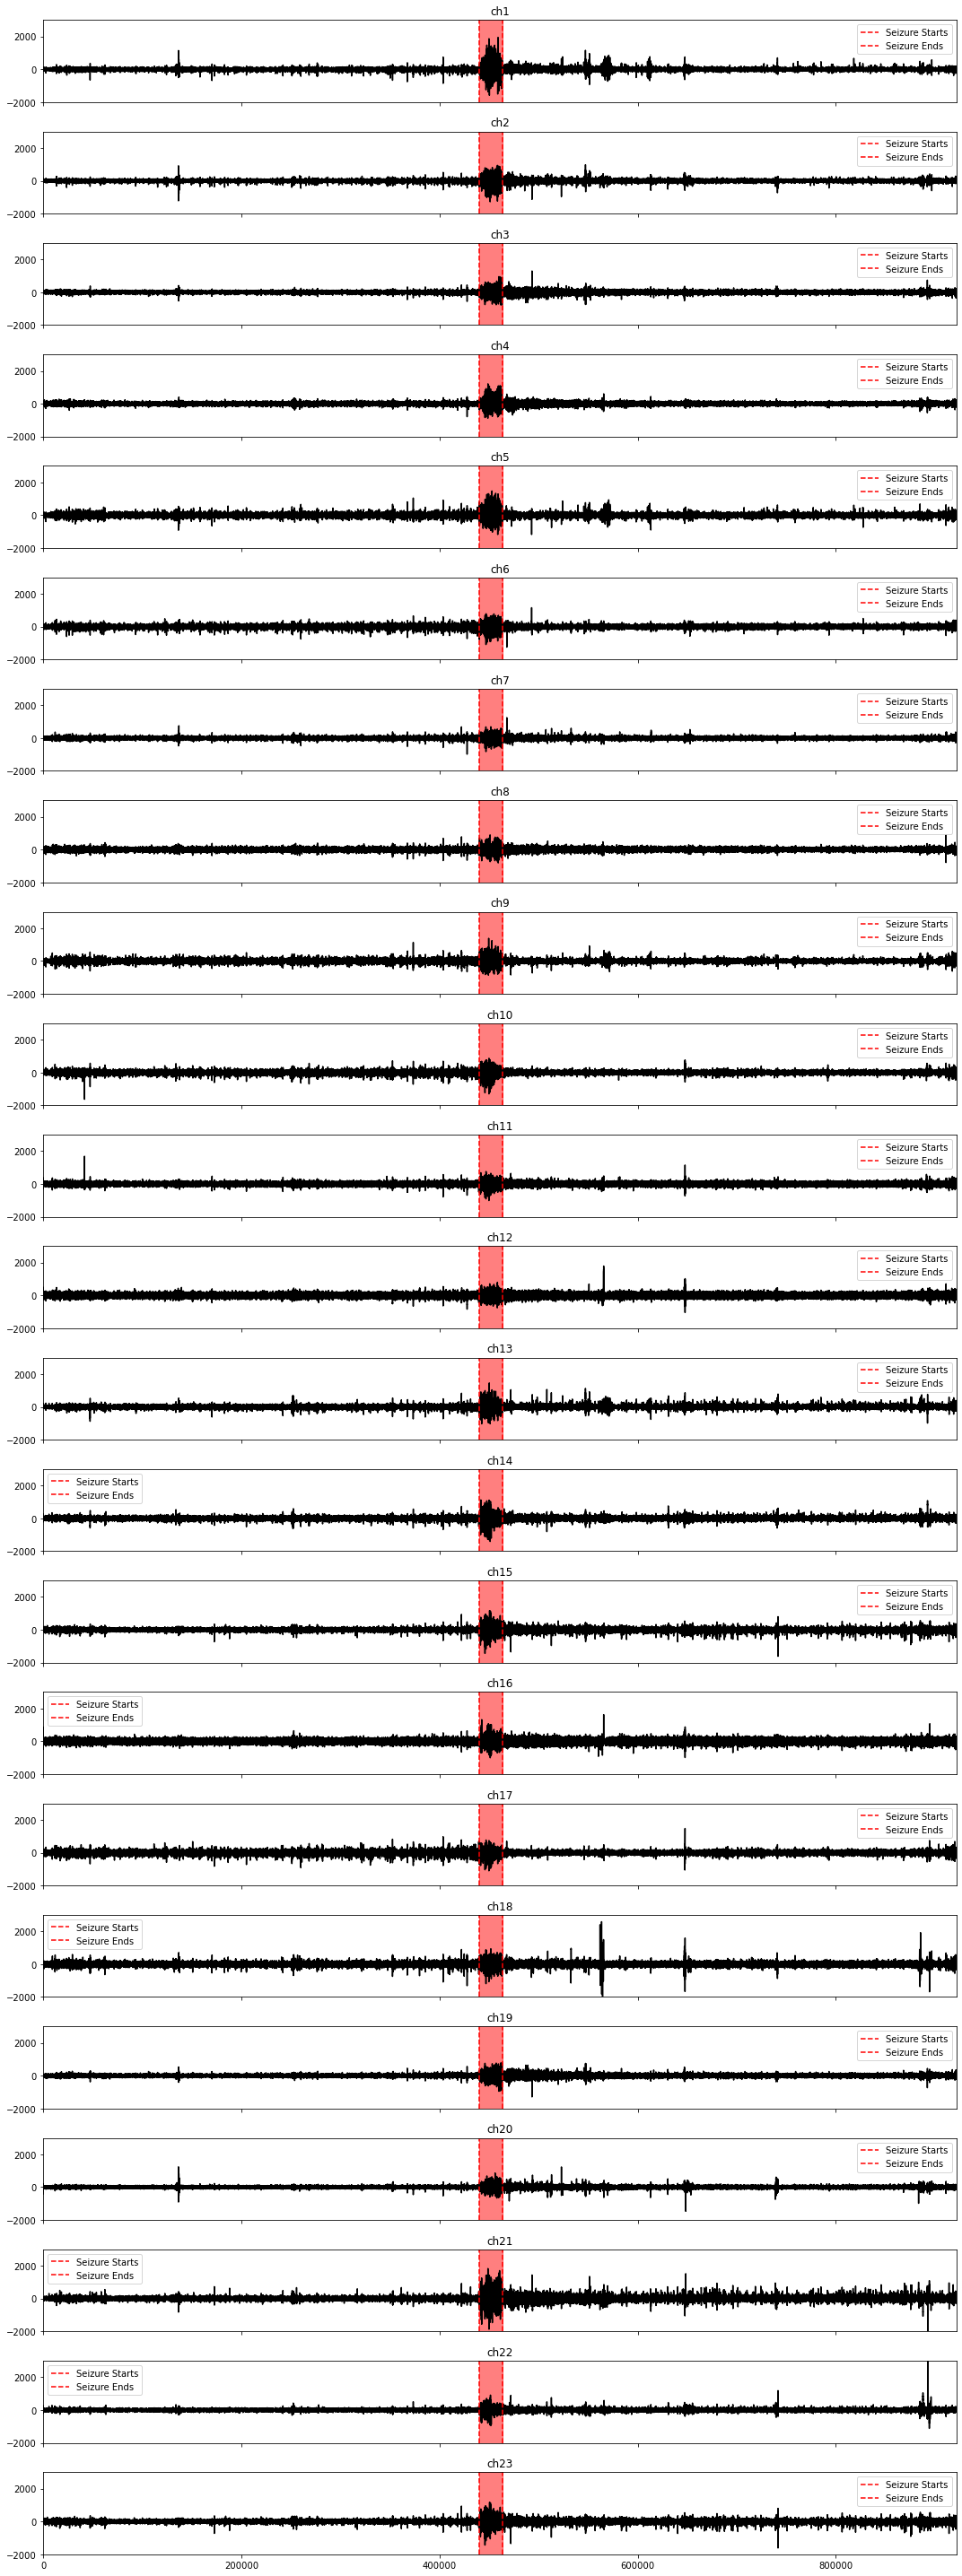

In [4]:
plot(dataframes=eeg_df, starts=seizure_starts_sr, ends=seizure_ends_sr, name='EEG Signal', x_min=0, x_max=num_samples)


I selected a window of samples during normal/seizure activity for a better visualization.

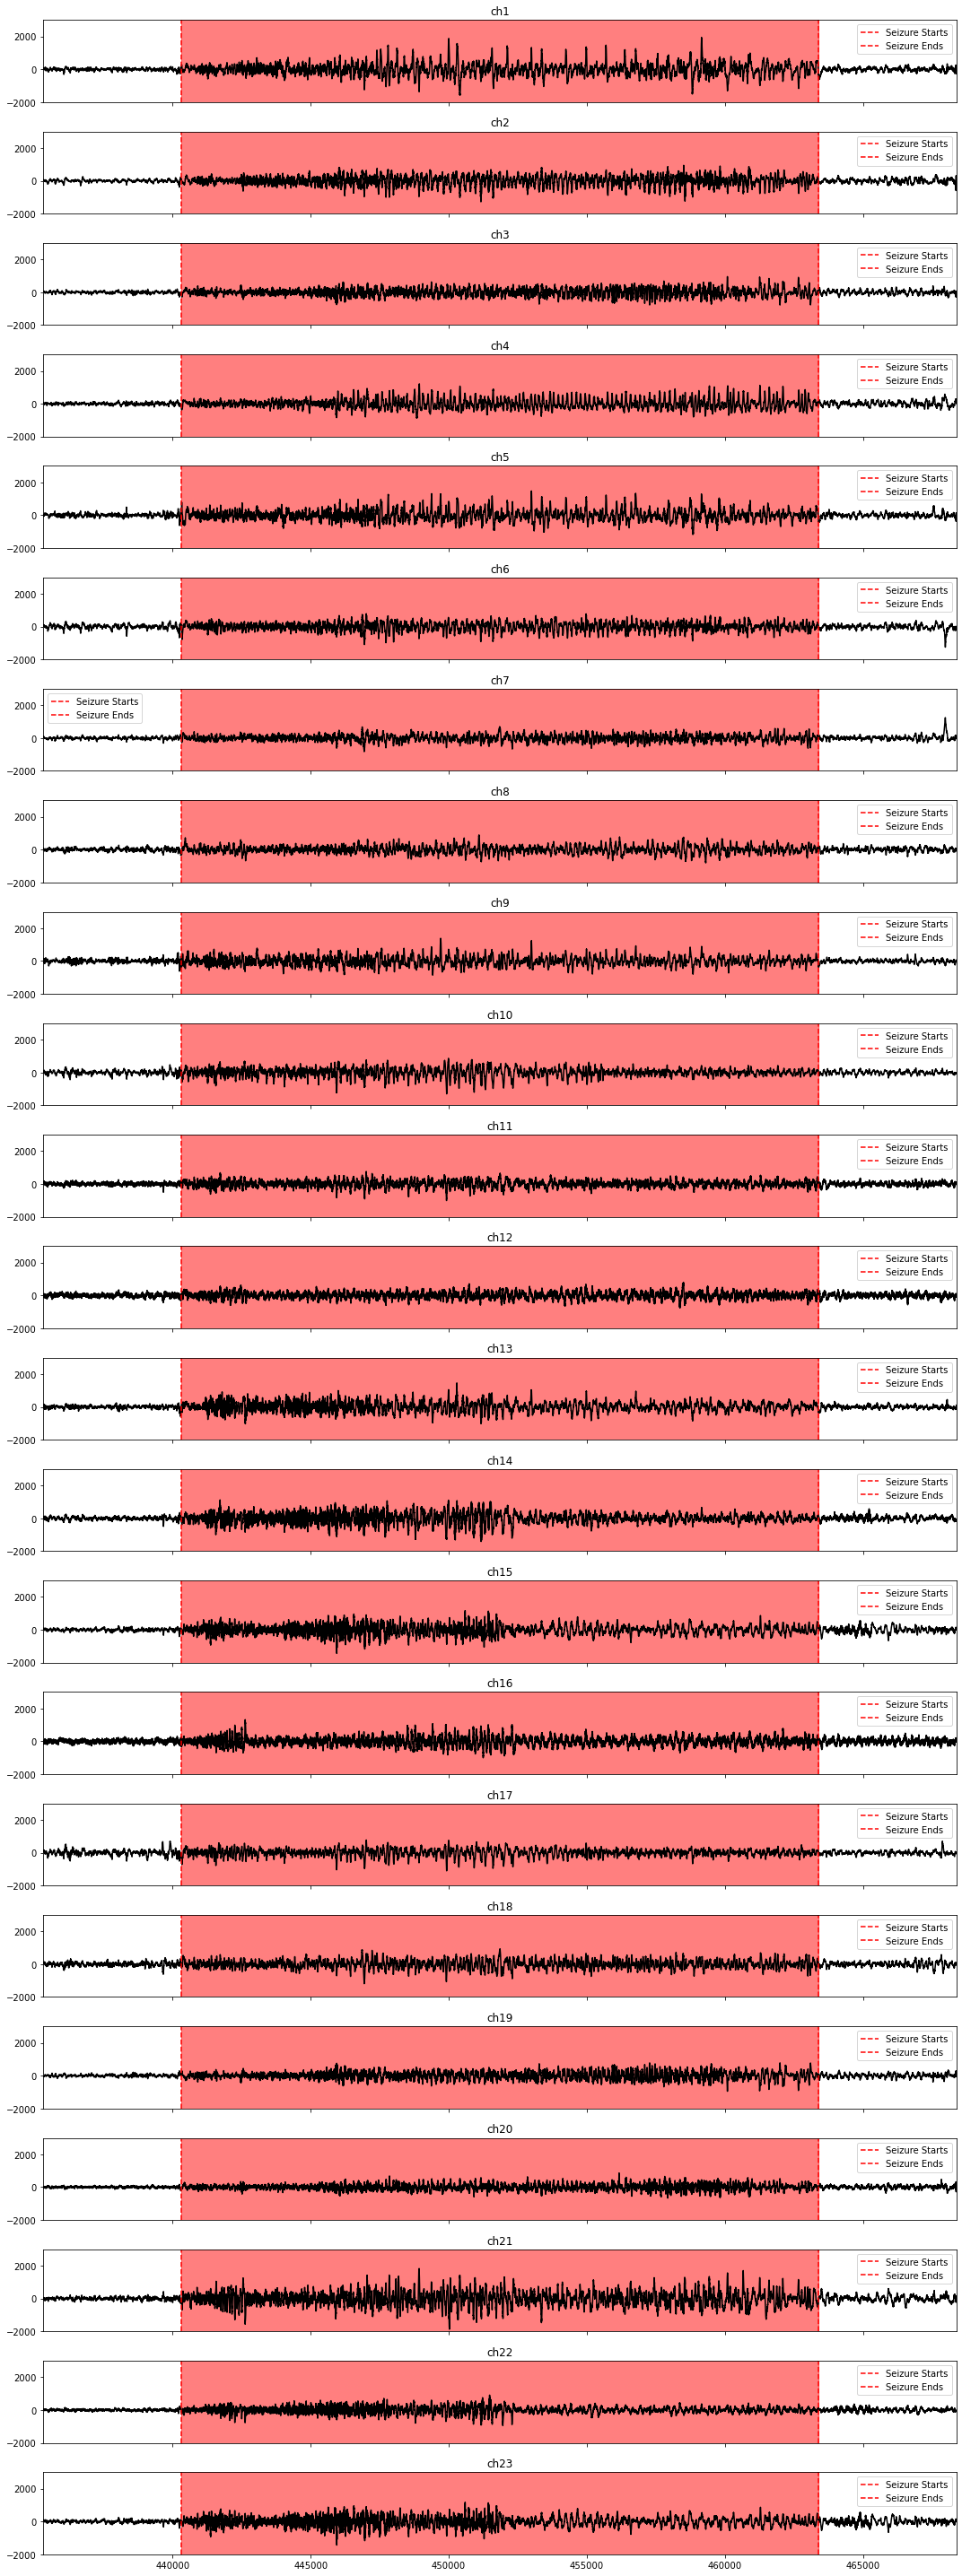

In [5]:
plot(dataframes=eeg_df, starts=seizure_starts_sr, ends=seizure_ends_sr, name='EEG Signal', x_min=seizure_starts_sr-5000, x_max=seizure_ends_sr+5000)

### 2- DC Removal
Remove DC component

In [6]:
dc_removed = eeg_df - eeg_df.mean()

## 2- Plot After DC Removal

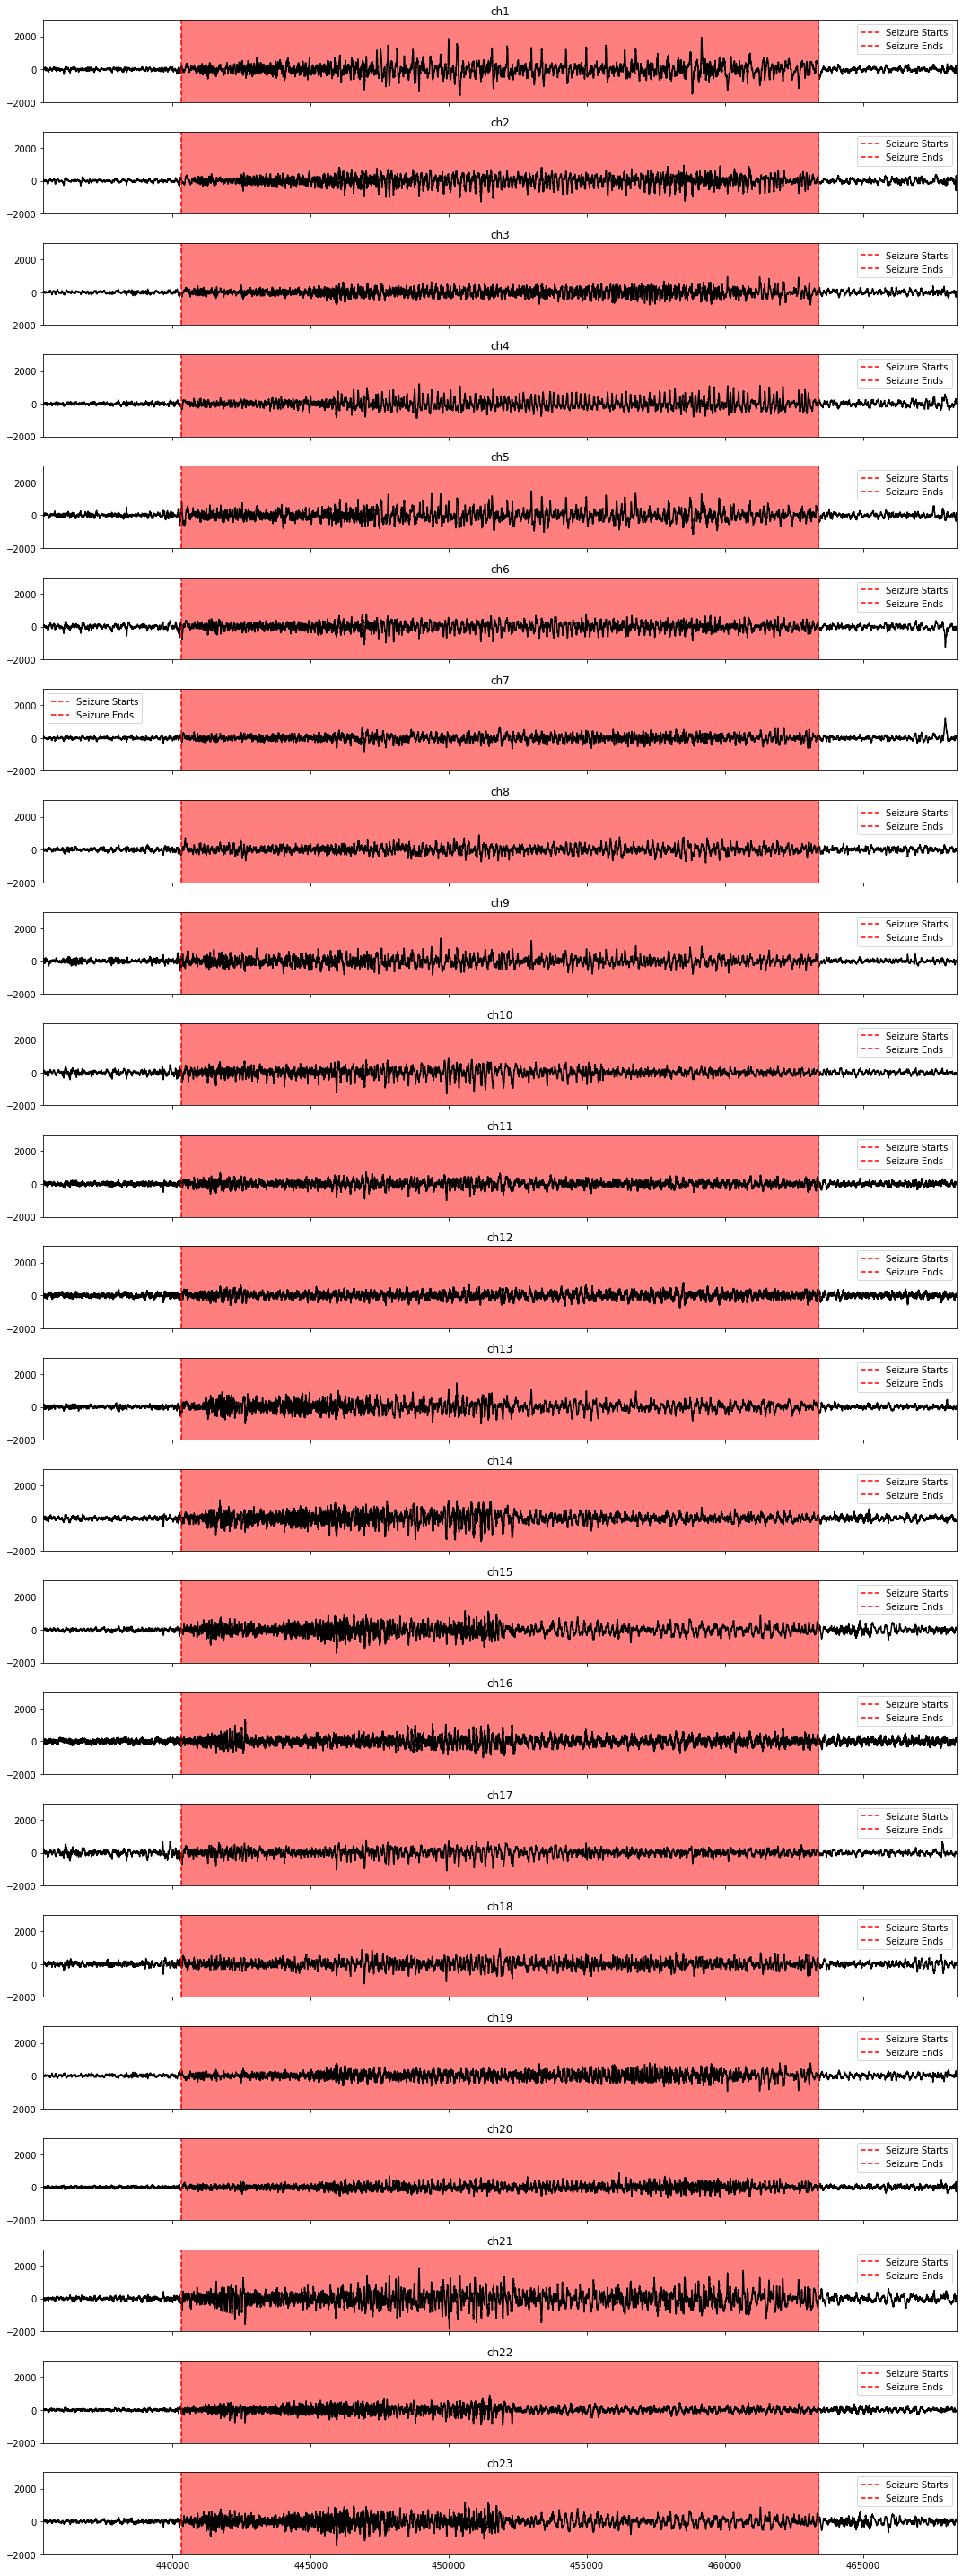

In [7]:
plot(dataframes=dc_removed, starts=seizure_starts_sr, ends=seizure_ends_sr, name='EEG Signal after DC removal', x_min=seizure_starts_sr-5000, x_max=seizure_ends_sr+5000)

### EEG Signal Filtering:

Digital filtering is a common preprocessing step when analyzing EEG data. The typical practice in EEG signal processing is to apply a high-pass filter to filter out slow frequencies less than 0.1 Hz or often even 1 Hz and a low-pass filter to filter out frequencies above 40 or 50 Hz Hz.  

Some suggested guidelines:

High-pass filtering, preferably only in cases where large drifts in the data are present.
Setting a proper cut-off frequency for high-pass filtering is crucial. Lower values in the range of 0.01-0.05 is preferred. Higher cut-off may distort the data considerably.
Playing around with few cut-off frequencies for high-pass filtering and seeing how it affects the data might be useful.
Causal or non-causal? This depends on your goal. As mentioned before, acausal filtering can cause the ERP onset to be earlier than it actually is. So if you are interested in the timing of earliest event avoid non-causal filtering.
Most of all, know what kind of filter your software package uses. EEGLAB uses a zero phase FIR filter as a default (it uses the filtfilt() function in MATLAB). FieldTrip (a MATLAB toolbox for EEG and MEG uses a Butterworth filter (IIR) as default. Butterworth filters typically provide flat passband, but this comes at a price of broad transition band. Other IIR filter types include Chebyshev and Elliptic filters, which provide a narrow transition band at the cost of ripples in in passband .

Source: https://sapienlabs.org/lab-talk/pitfalls-of-filtering-the-eeg-signal/

### 3- Moving Average Filter

What is Moving Average filter?
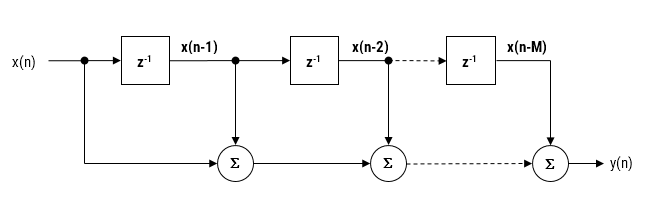
$ y(n) = 1/L \sum \limits _{k=1} ^{L-1} x(n-k),\ for\ n = 0, 1, 2, 3, ... $ <br>
The moving average filter is a simple type of a Low Pass filter, which reduce (or remove) signal rapid variation (high frequency noise) and  doesn't have any control over its bandwidth for a fixed number of taps. This filter commonly used for smoothing an array of sampled data/signal. It takes M samples of input at a time and take the average of those M-samples and produces a single output point.
The moving average is the most common filter in DSP, mainly because it is the easiest digital filter to understand and use. In spite of its simplicity, the moving average filter is optimal for a common task: reducing random noise while retaining a sharp step response. With a moving average filter the filter is narrowly focused around the 0 Hz component ("DC"), and the peak gets narrower the more taps you have in the filter. Another problem with using a moving average filter as an LPF is that it has high sidelobes (the ripples to either side of the main peak) compared to a "properly designed" filter.

Advantages:

- Most commonly used digital low pass filter.
- Good smoother (time domain).
- Unity valued filter coefficients, no MAC (multiply and accumulate) operations required.
- Conceptually simple to implement.

Disadvantages:

- Inflexible frequency response: nudging a conjugate zero pair results in non-unity coefficients.
- Poor lowpass filter (frequency domain): slow roll-off and terrible stopband attenuation characteristics.


Use moving average filters to remove high frequency components to smooth the signal and noise removal. <br>
Results shows between degree choices {10, 50, 1000}, degree = 10 is the best choice and for degree = 1000 we see negative effect and the main signal is totally ruined.

In [14]:
import numpy as np
from scipy.ndimage.filters import uniform_filter1d
import numpy as np

# def moving_average(df, degree):
    
    
#     df_ma = pd.DataFrame.from_records(uniform_filter1d(df, size=degree))
#     cols = ["ch" + str(col+1) for col in df_ma.columns.values.tolist()]
#     df_ma.columns = cols
#     return df_ma
def moving_average(df, degree):

    df_ma = df.iloc[:,:].rolling(min_periods=1, window=degree).mean()
    return df_ma

df_ma10 = moving_average(dc_removed, degree=10)
df_ma50 = moving_average(dc_removed, degree=50)
df_ma1000 = moving_average(dc_removed, degree=1000)


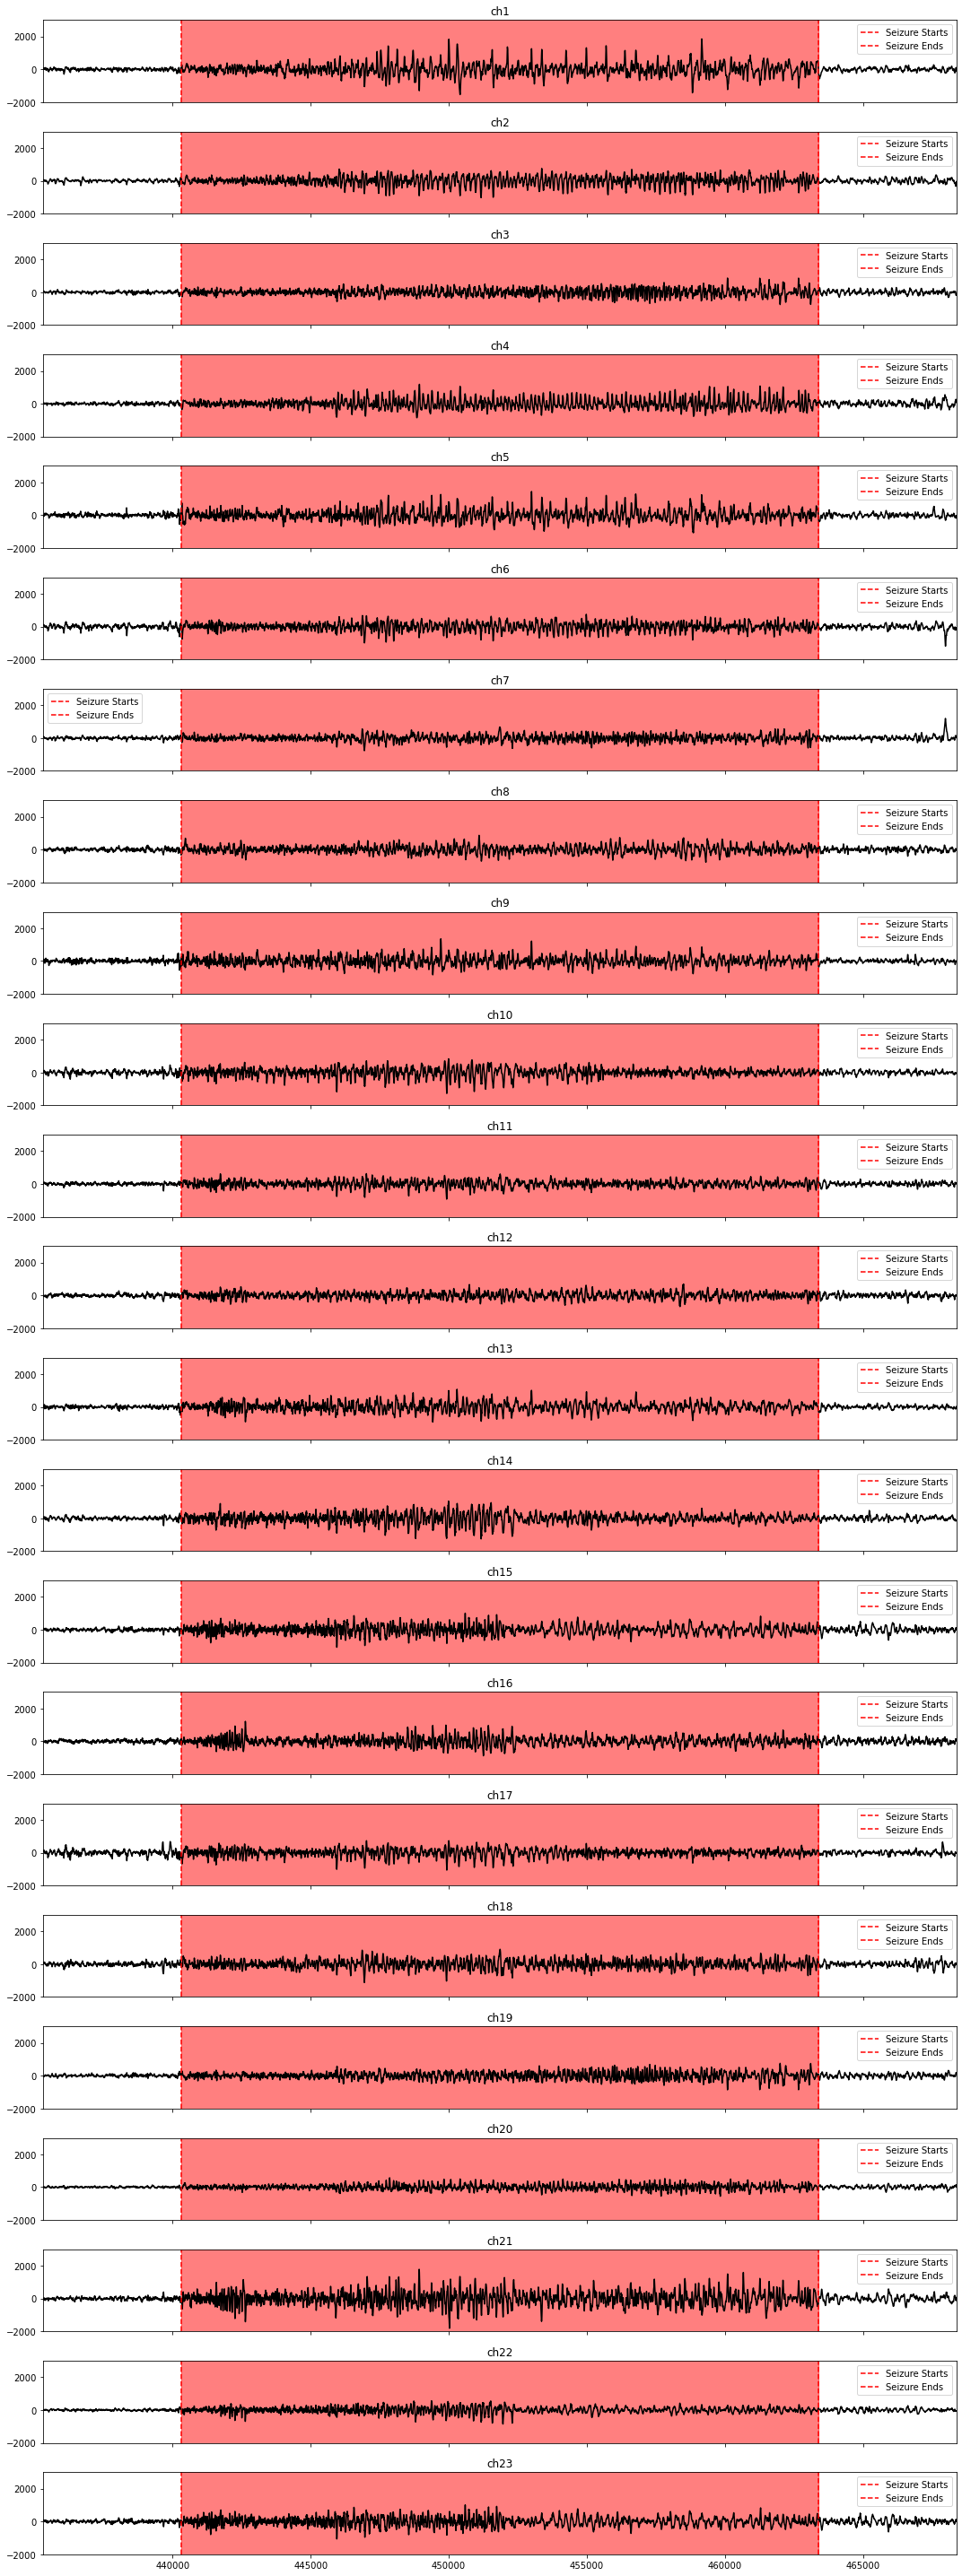

In [15]:
plot(dataframes=df_ma10, starts=seizure_starts_sr, ends=seizure_ends_sr, name='EEG Signal after Moving Average with order 10 Zoomed', x_min=seizure_starts_sr-5000, x_max=seizure_ends_sr+5000)


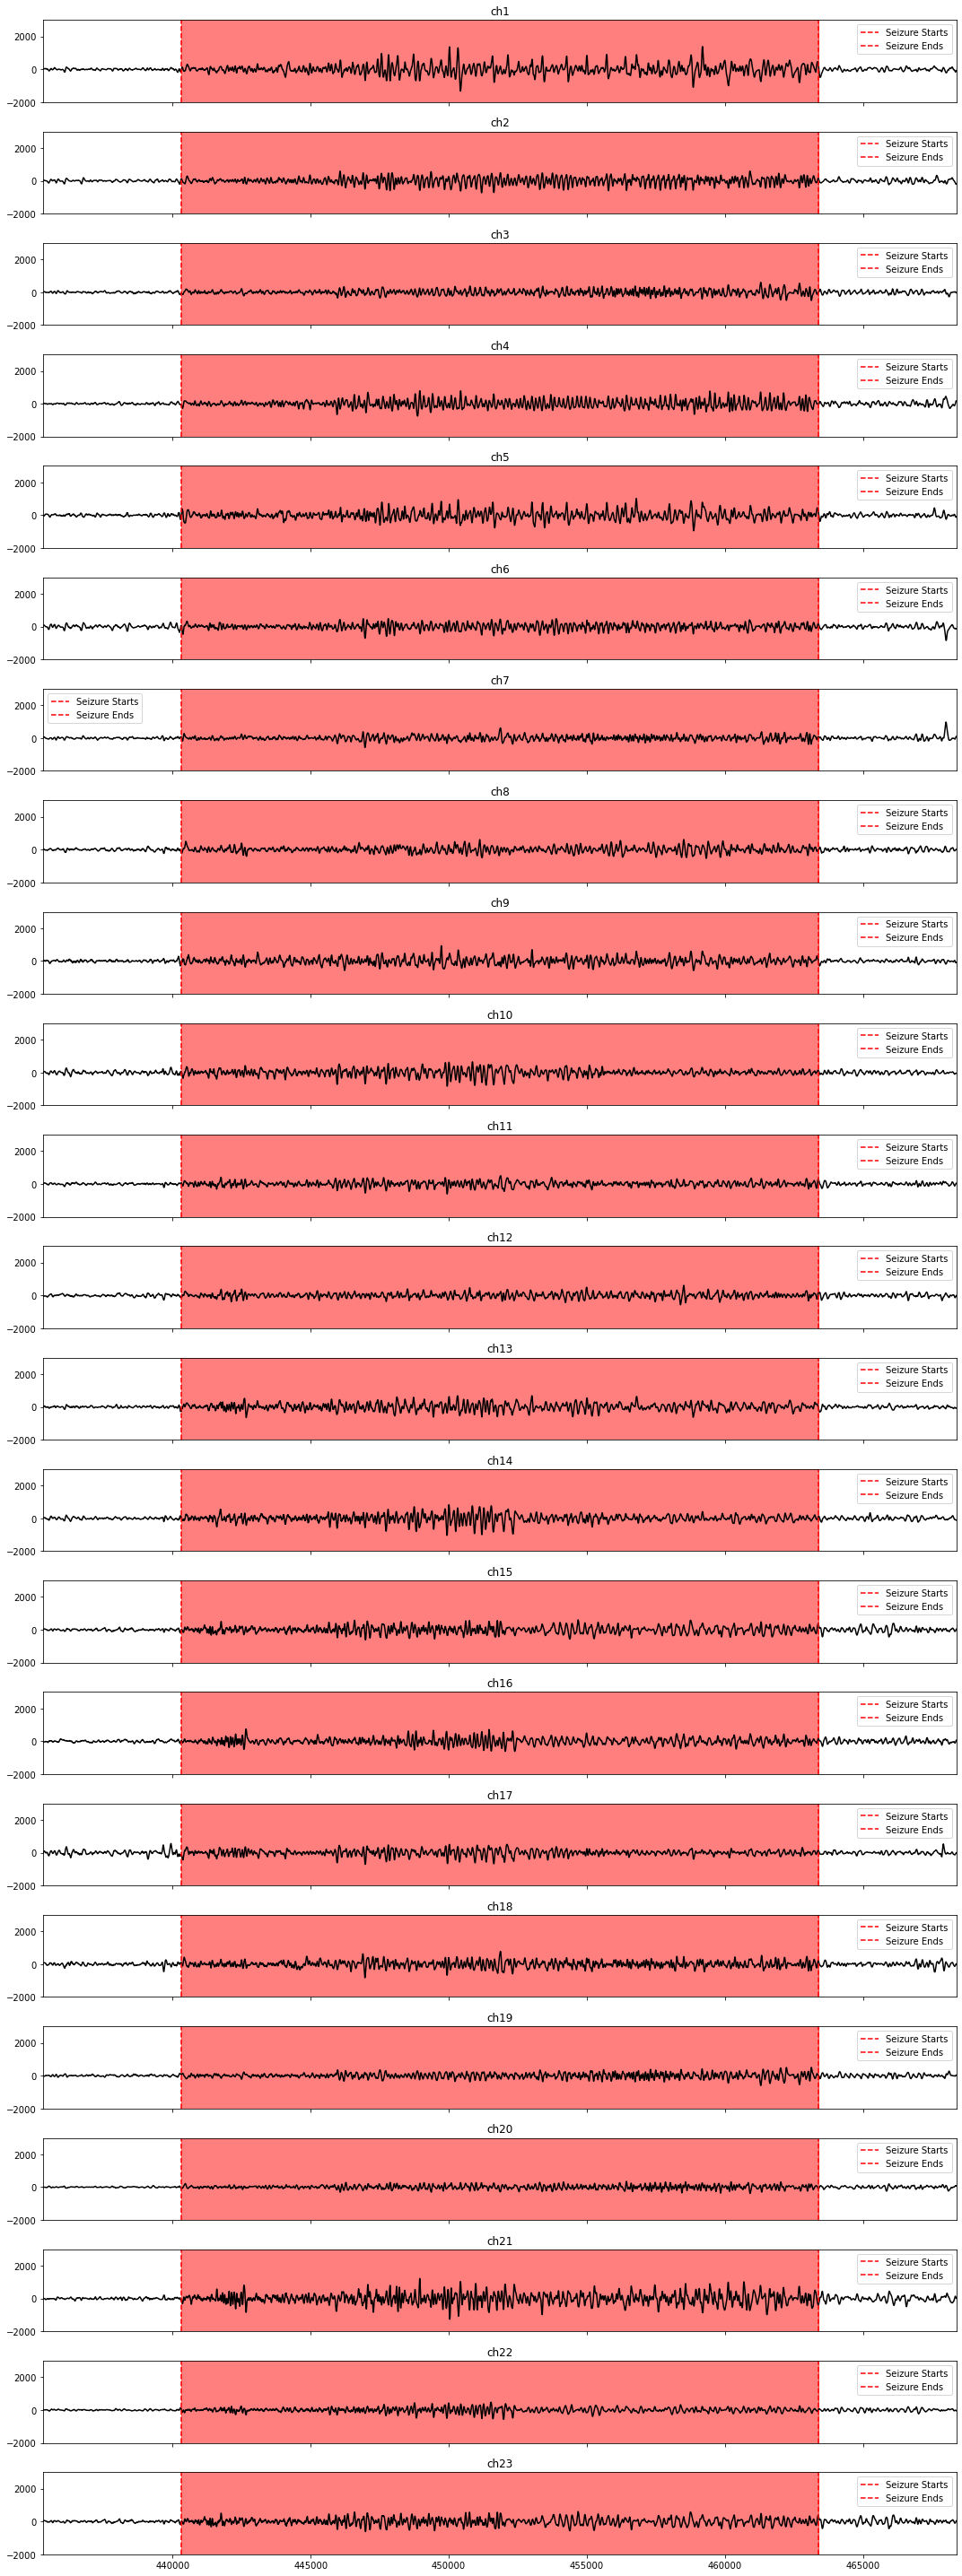

In [10]:
plot(dataframes=df_ma50, starts=seizure_starts_sr, ends=seizure_ends_sr, name='EEG Signal after Moving Average with order 50 Zoomed', x_min=seizure_starts_sr-5000, x_max=seizure_ends_sr+5000)


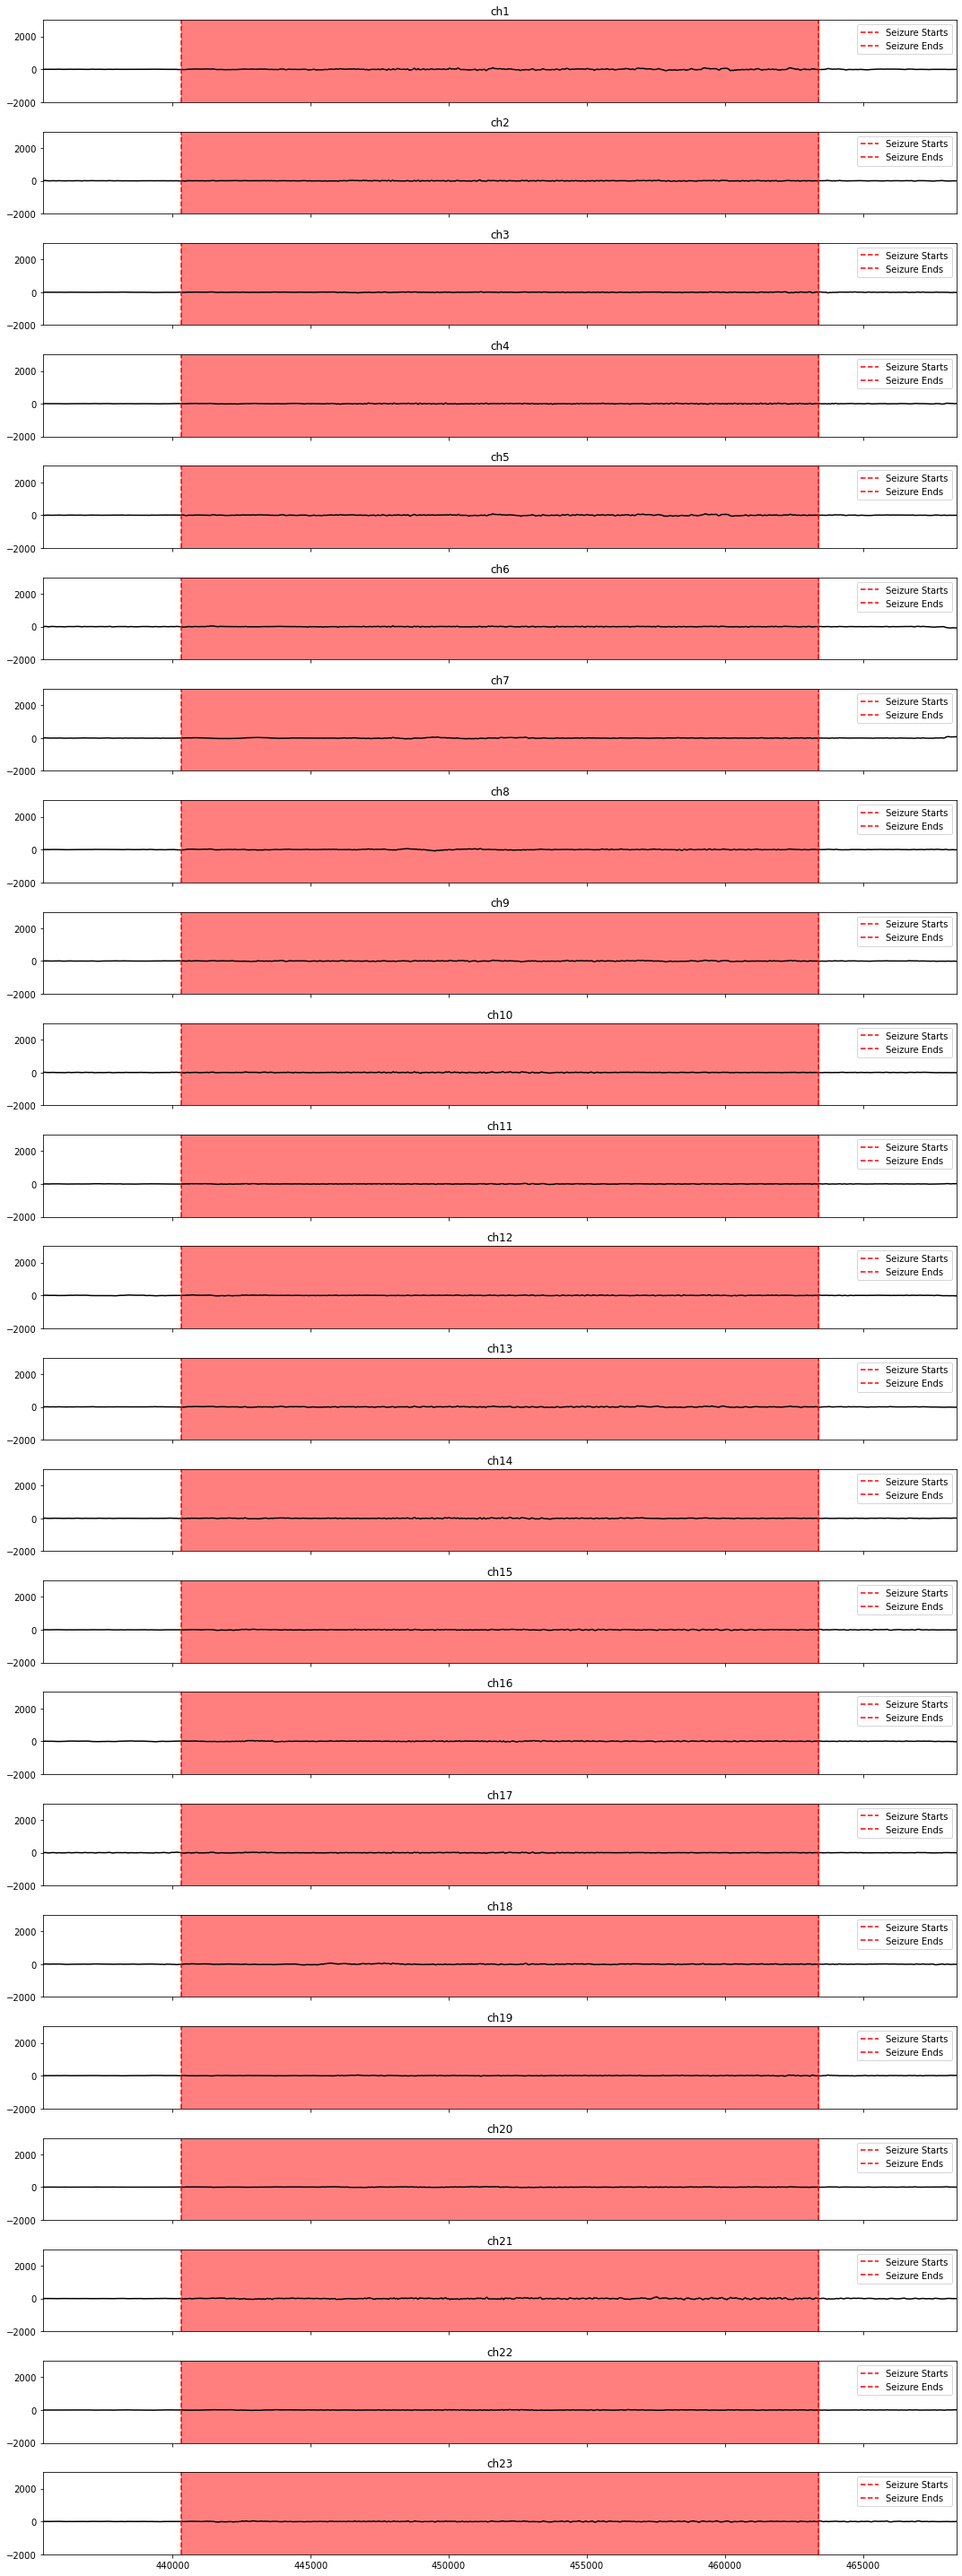

In [11]:
plot(dataframes=df_ma1000, starts=seizure_starts_sr, ends=seizure_ends_sr, name='EEG Signal after Moving Average with order 1000 Zoomed', x_min=seizure_starts_sr-5000, x_max=seizure_ends_sr+5000)


### Low frequency noise:

After high frequency noise removal with a simple moving average filter, as shown, we have to remove low frequency noise. for removing low frequency noise we use FIR, IIR filters.

Here I used Kaiser filter.

## 5-a Apply FIR filters

In [16]:
from scipy.signal import kaiserord, lfilter, firwin, freqz

#--------FIR Filter------

vals = (df_ma10.transpose()).values.tolist()
nsamples = len(vals[0])
t = np.arange(nsamples) / sample_rate

nyq_rate = sample_rate / 2.0
width = 5.0/nyq_rate

ripple_db = 60.0
N, beta = kaiserord(ripple_db, width)
cutoff_hz = 0.05
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

filtered_vals = []
for i in range(len(vals)):
    filtered_val = lfilter(taps, 1.0, vals[i])
    filtered_vals.append(filtered_val)

filtered = pd.DataFrame(filtered_vals)
df_FIRfiltered = filtered.transpose()
df_FIRfiltered.columns = ['ch'+str(n) for n in range(1,24)]

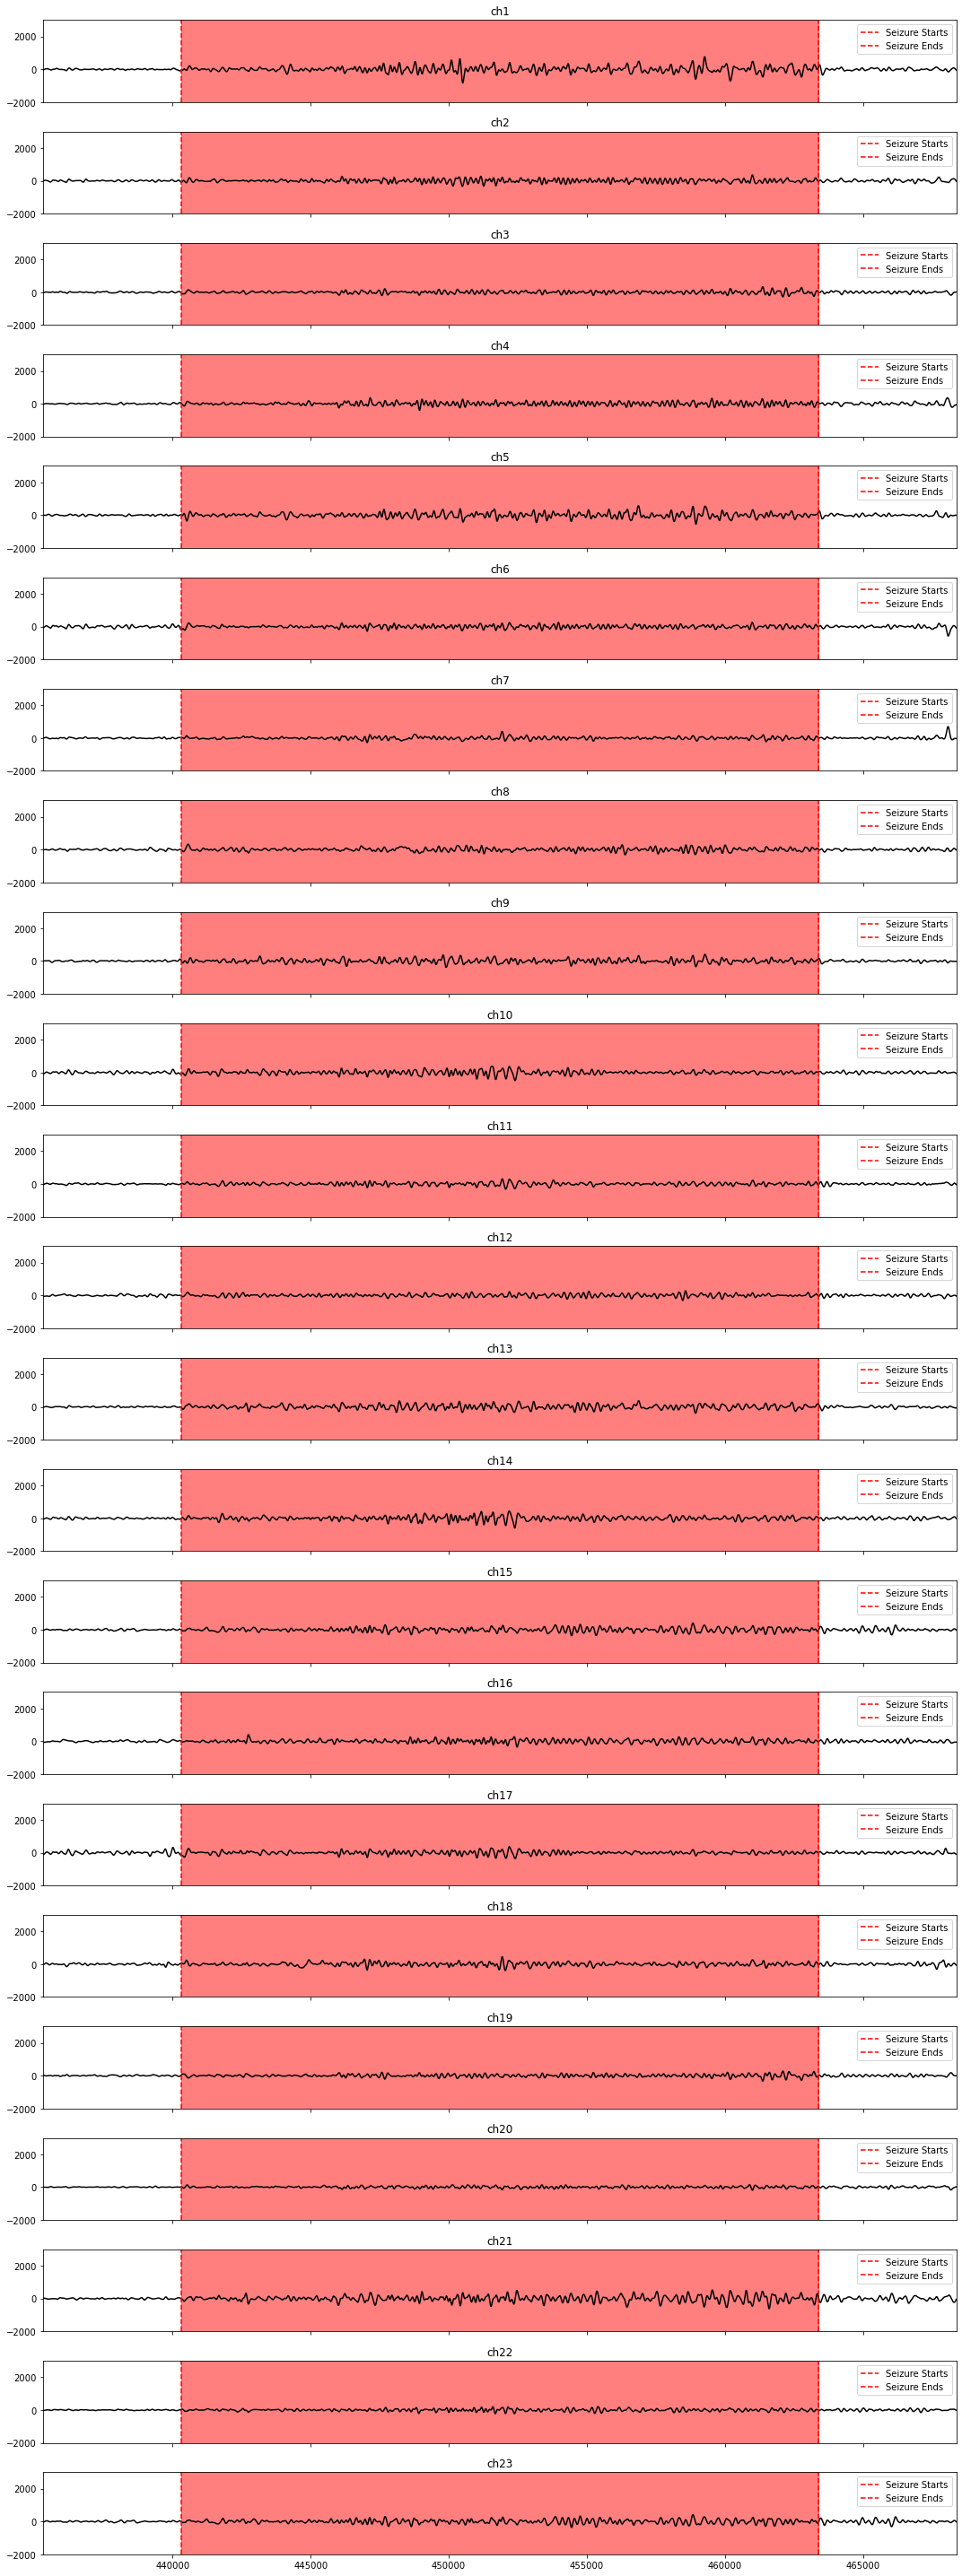

In [17]:
plot(dataframes=df_FIRfiltered, starts=seizure_starts_sr, ends=seizure_ends_sr, name='EEG Signal after FIR filter', x_min=seizure_starts_sr-5000, x_max=seizure_ends_sr+5000)


## 5-b Plot of Phase Response 

<ipython-input-31-88d49338aa0e>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


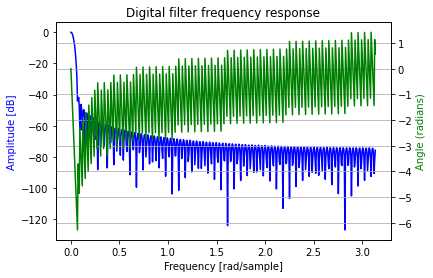

In [31]:
w_fir, h_fir = freqz(taps)


fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)

plt.plot(w_fir, 20 * np.log10(abs(h_fir)), 'blue')
plt.ylabel('Amplitude [dB]', color='blue')
plt.xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h_fir))
plt.plot(w_fir, angles, 'green')
plt.ylabel('Angle (radians)', color='green')
plt.grid()
plt.axis('tight')
plt.show()

## 5-c Apply IIR filters

EEG IIR Filter - Zero Phase Shift Butterworth Filters

The Infinite Impulse Response (IIR) Filters transform allows us to filter or attenuate undesired

frequency (spectral) components that are present in the EEG data. For example, it is typically

desired to attenuate high-frequency noise in order to create a smoother representation

of the raw EEG signal or an ERP. Likewise, slow-frequency components can be filtered out to

eliminate long-lasting offsets of non-physiological origin in oscillatory EEG signals.

The IIR Filters in Analyzer are phase-shift free Butterworth filters.

In [32]:
from scipy.signal import butter, filtfilt, freqs

#--------IIR Filter------

nsamples = len(vals[0])
t_iir = np.arange(nsamples) / sample_rate

fc = 5
w = fc / (sample_rate / 2)
b, a = signal.butter(5, w, 'low')

filtered_vals_IIR = []
for i in range(len(vals)):
    filtered_val_IIR = signal.filtfilt(b, a, vals[i])
    filtered_vals_IIR.append(filtered_val_IIR)

filtered_IIR = pd.DataFrame(filtered_vals_IIR)
df_IIRfiltered = filtered_IIR.transpose()
df_IIRfiltered.columns = ['ch'+str(n) for n in range(1,24)]

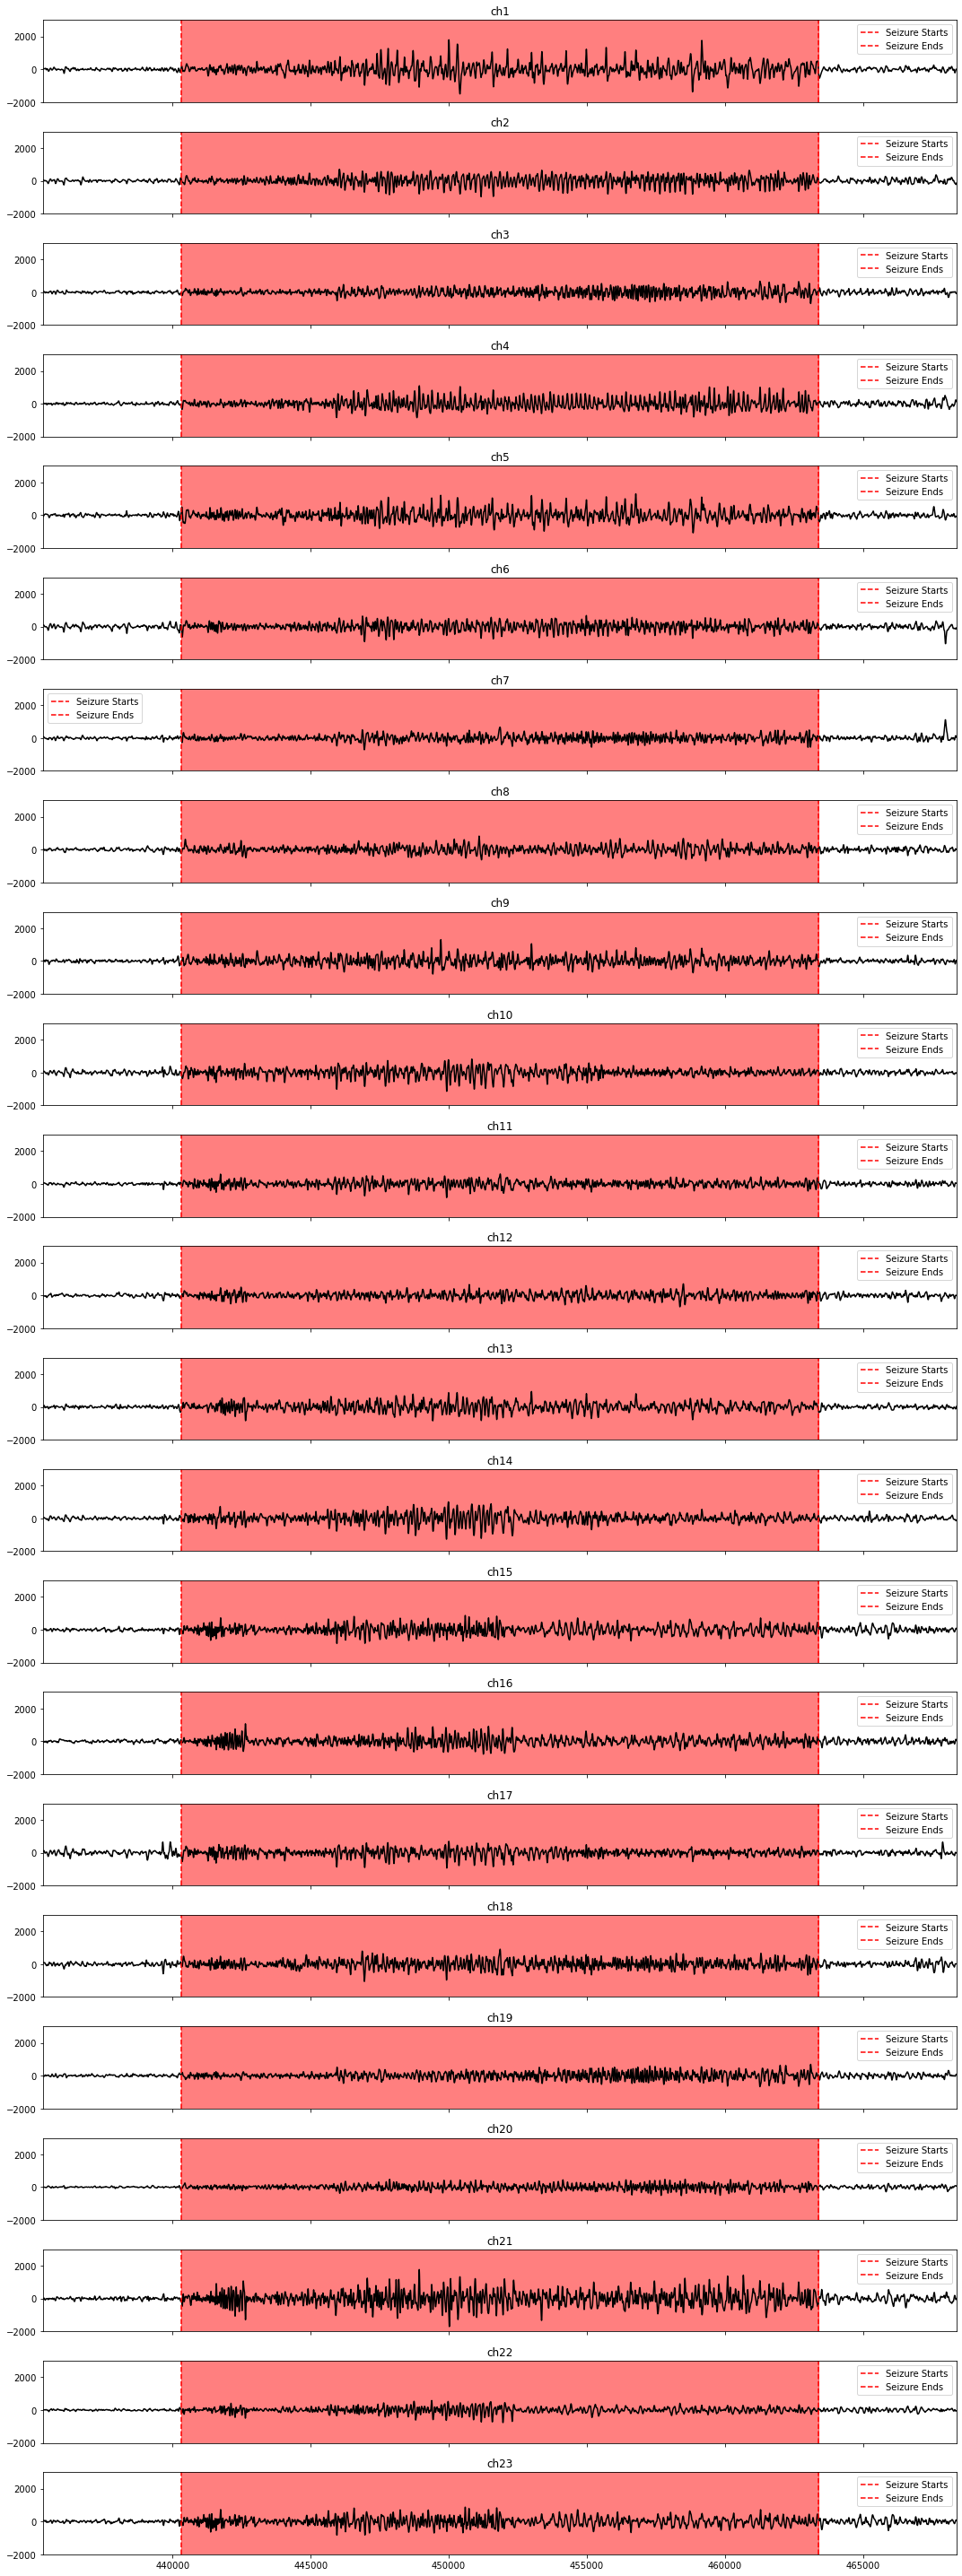

In [33]:
plot(dataframes=df_IIRfiltered, starts=seizure_starts_sr, ends=seizure_ends_sr, name='EEG Signal after IIR filter', x_min=seizure_starts_sr-5000, x_max=seizure_ends_sr+5000)


## 5-c Plot of Phase Response 

<ipython-input-34-cd0c4d5f1bb3>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


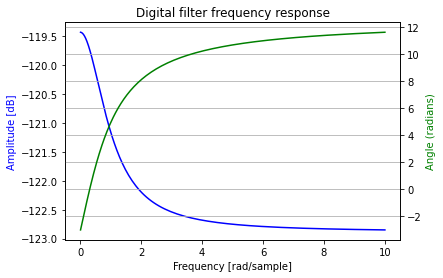

In [34]:
w_iir, h_iir = freqs(b, a)

fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)

plt.plot(w_iir, 20 * np.log10(abs(h_iir)), 'blue')
plt.ylabel('Amplitude [dB]', color='blue')
plt.xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h_iir))
plt.plot(w_iir, angles, 'green')
plt.ylabel('Angle (radians)', color='green')
plt.grid()
plt.axis('tight')
plt.show()

## Apply FIR filter after IIR filter

In [35]:
from scipy.signal import kaiserord, lfilter, firwin, freqz

FIR_IIR = (df_IIRfiltered.transpose()).values.tolist()

#--------FIR Filter on the results of IIR Filter------

nsamples_firiir = len(FIR_IIR[0])
t_firiir = np.arange(nsamples_firiir) / sample_rate

nyq_rate = sample_rate / 2.0
width_firiir = 5.0/nyq_rate

ripple_db = 60.0
N, beta = kaiserord(ripple_db, width_firiir)
cutoff_hz_firiiir = 0.05
taps_firiir = firwin(N, cutoff_hz_firiiir/nyq_rate, window=('kaiser', beta))

filtered_firiirs = []
for i in range(len(FIR_IIR)):
    ffiltered_firiir = lfilter(taps_firiir, 1.0, FIR_IIR[i])
    filtered_firiirs.append(ffiltered_firiir)

filtered_firiiir = pd.DataFrame(filtered_firiirs)
df_FIRIIRfiltered = filtered_firiiir.transpose()
df_FIRIIRfiltered.columns = ['ch'+str(n) for n in range(1,24)]

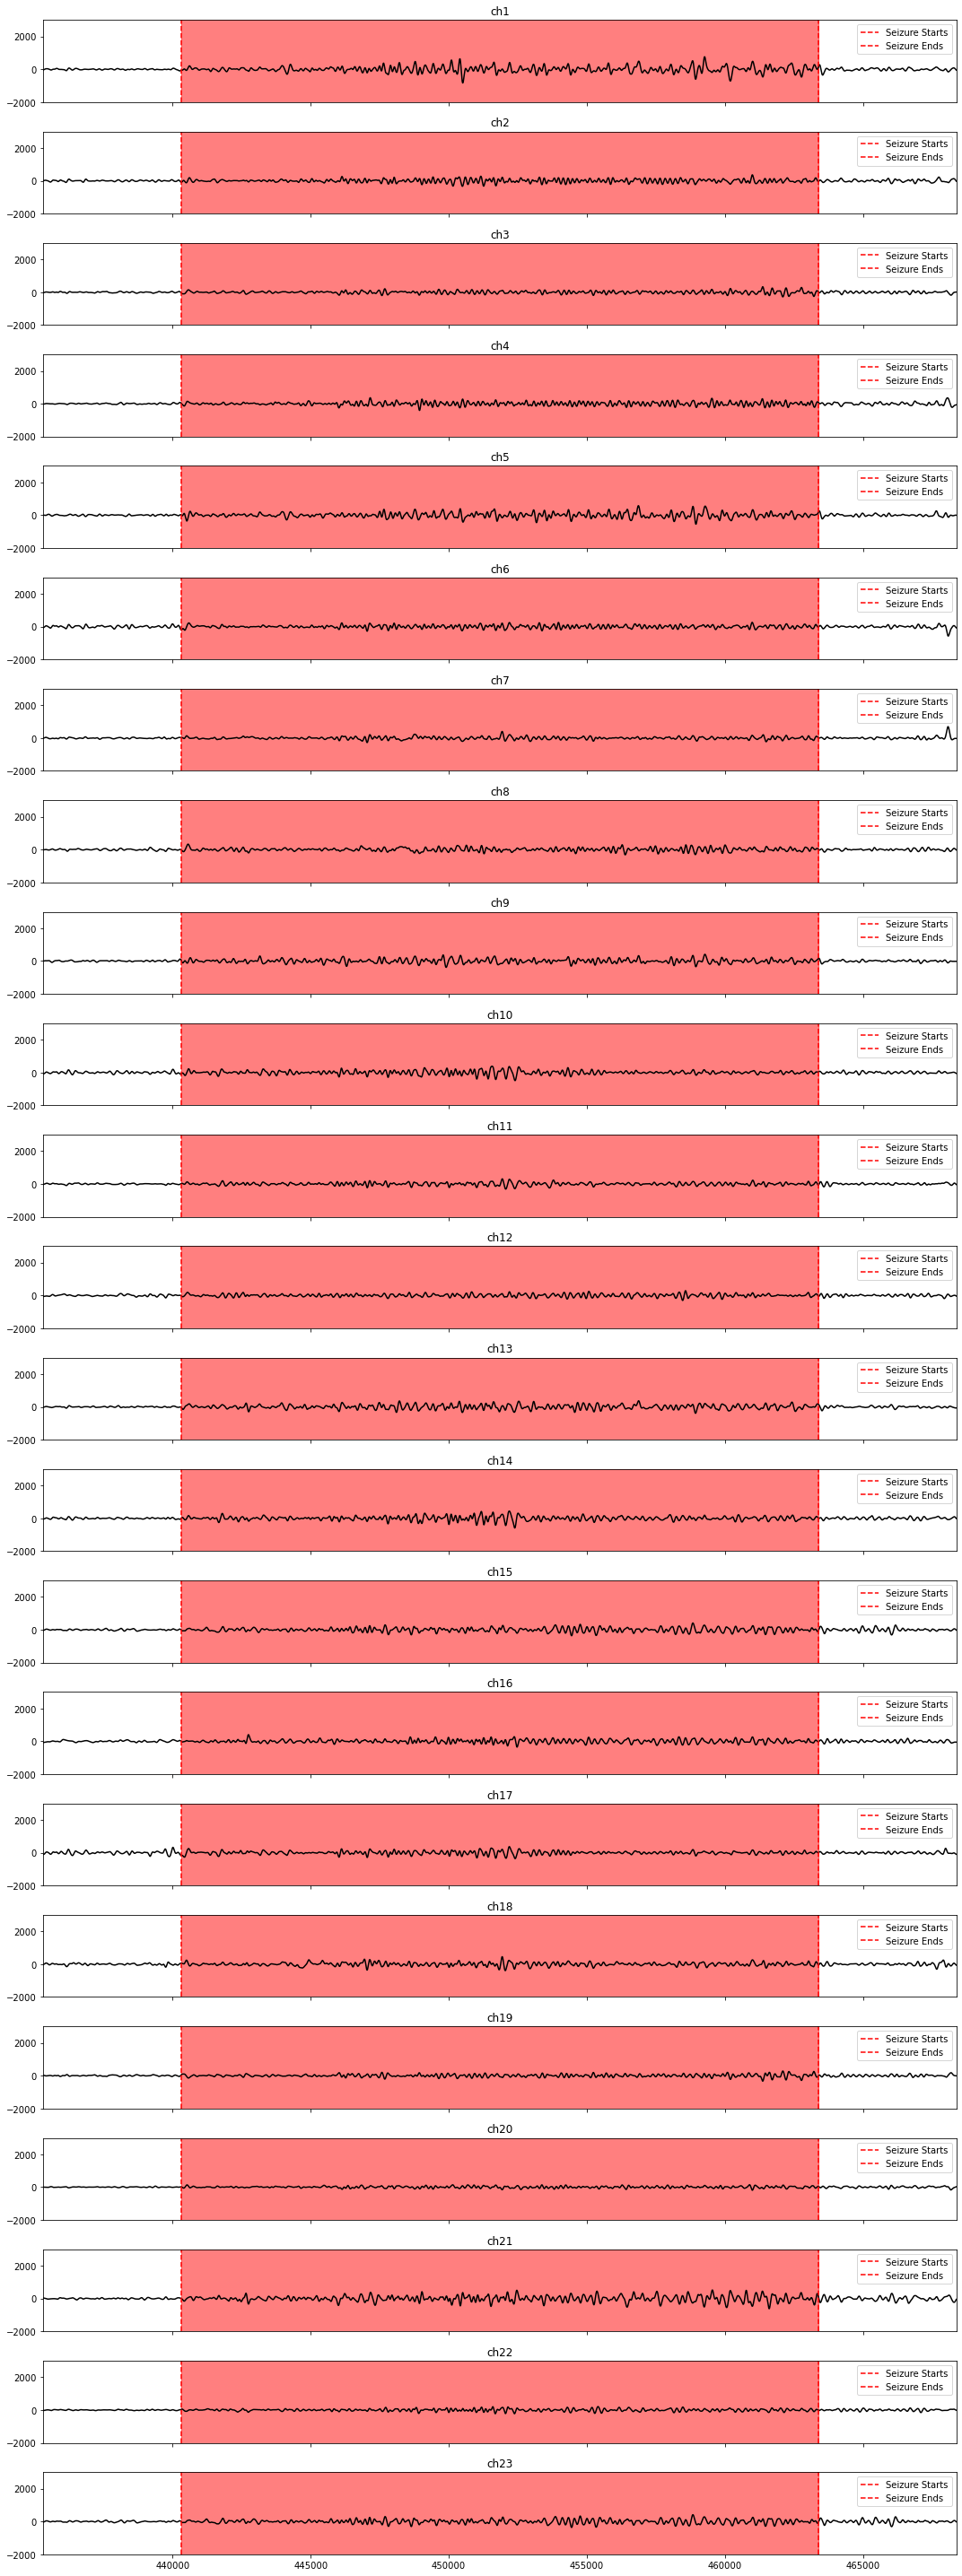

In [36]:
plot(dataframes=df_FIRIIRfiltered, starts=seizure_starts_sr, ends=seizure_ends_sr, name='EEG Signal FIR after IIR filter', x_min=seizure_starts_sr-5000, x_max=seizure_ends_sr+5000)


## EEG Bands for Normal Signal

In [47]:
from scipy.fft import fft, fftfreq
def fft_signal(eeg_signal):
    
    fs=sample_rate
    N_signal = len(eeg_signal)
    fft_vals_signal = np.abs(fft(eeg_signal))
    fft_freq_signal = fftfreq(N_signal, 1.0/fs)
    return fft_vals_signal, fft_freq_signal


def plot_eeg_bands(fft_vals, fft_freq):
    
    #define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}
    
    eeg_band_fft = dict()
    for band in eeg_bands:
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_ylim(0, 500)
    ax.set_title("EEG Bands after Applying Filters")
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude")


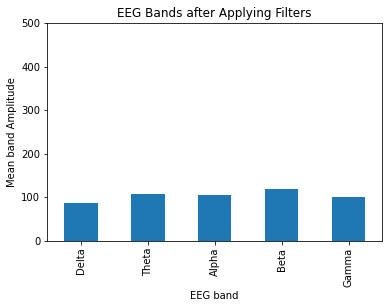

In [48]:
normal_end = seizure_starts_sr - sample_rate * 5
df_normal_FIRIIR = df_FIRIIRfiltered.iloc[0 : normal_end, :]
df_normal_reset_FIRIIR = df_normal_FIRIIR.reset_index(drop=True)
normal_data = df_normal_reset_FIRIIR.values
fft_vals_normal,  fft_freq_normal = fft_signal(eeg_signal=normal_data)
plot_eeg_bands(fft_vals=fft_vals_normal, fft_freq=fft_freq_normal)

## EEG Bands during Seizure Signal

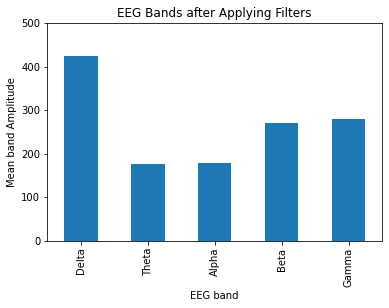

In [49]:
df_seizure_FIRIIR = df_FIRIIRfiltered.iloc[seizure_starts_sr : seizure_ends_sr, :]
df_seizue_reset_FIRIIR = df_seizure_FIRIIR.reset_index(drop=True)
seizure_data = df_seizue_reset_FIRIIR.values
fft_vals_seizure,  fft_freq_seizure = fft_signal(eeg_signal=seizure_data)
plot_eeg_bands(fft_vals=fft_vals_seizure, fft_freq=fft_freq_seizure)


## FFT of EEG Signal during Seizure after DC Removal, Moving Average, IIR Filter, FIR Filter.

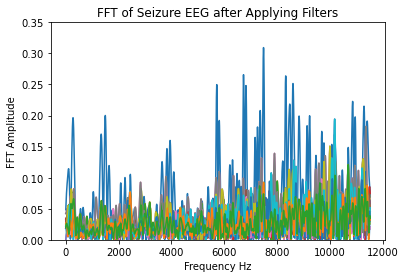

In [55]:
N = len(fft_vals_seizure)
f = (seizure_ends - seizure_starts) * sample_rate
T = 1.0 / f
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * fft_vals_seizure[:N//2])
ax.set_title("FFT of Seizure EEG after Applying Filters")
ax.set_ylim(0, 0.35)
ax.set_xlabel("Frequency Hz")
ax.set_ylabel("FFT Amplitude")
plt.show()


## FFT of Normal EEG Signal after DC Removal, Moving Average, IIR Filter, FIR Filter.

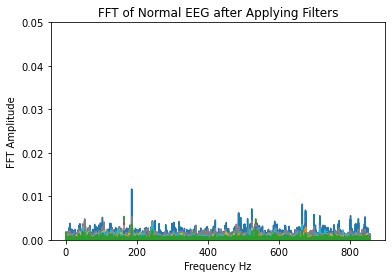

In [58]:
# Normal EEG Signal Before Seizure Happens
N = len(fft_vals_normal)
f = normal_end/sample_rate
T = 1.0 / f
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * fft_vals_normal[:N//2])
ax.set_title("FFT of Normal EEG after Applying Filters")
ax.set_ylim(0, 0.05)
ax.set_xlabel("Frequency Hz")
ax.set_ylabel("FFT Amplitude")
plt.show()

## Results:

- The results show that finite impulse response filters outperform infinite impulse response (IIR) filter while removing noise from the EEG signals.
- Moving average filters (low degree) are cheap, efficient filters to remove high frequency noise.
- Higher frequencies are often more common in abnormal brain states such as epilepsy, there is a shift of EEG signal energy from lower to higher frequency bands before and during a seizure.
- It can be noticed that the EEG signal power of is shifting from lower to higher frequencies in the presence of epileptiform activity.
